<hr>
<center> Learning Element for Control Systems - Autumn Semester 2023 <br>
<b> Learning Element 2 </b> <br>
Prof. Dr. Florian Dörfler <br>
Automatic Control Laboratory, ETH Zurich </center>
<hr>

In this notebook, you will find different code fragments to complete Learning Element 2. <b>

<!-- <blockquote> -->
<b>Activity:</b> Execute the code cells below so that the necessary libraries get imported.
<!-- </blockquote> -->

In [95]:
import numpy as np # the standard library for numerics, vectors, matrices
import control as ct # the standard library for basic operations for analysis and design of feedback control systems
import matplotlib.pyplot as plt # a comprehensive library for creating static, animated, and interactive visualizations
import math # access to the mathematical functions

<br>

<b> Code fragment for unstable zeros </b>


    -0.001 s + 2
--------------------
3e-05 s^3 + 0.06 s^2

3 states have been removed from the model

  -16.67 s^2 + 3.332e+04 s + 3.333e+04
----------------------------------------
s^3 + 1983 s^2 + 3.332e+04 s + 3.333e+04



Text(0, 0.5, '$\\Delta Z$')

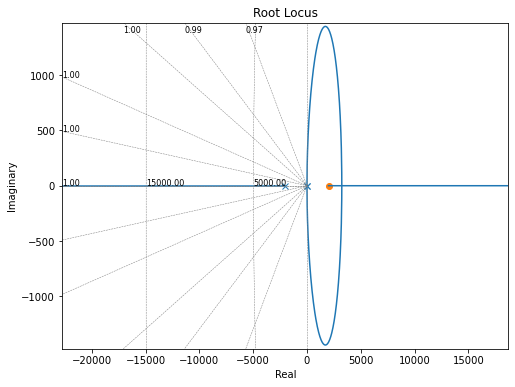

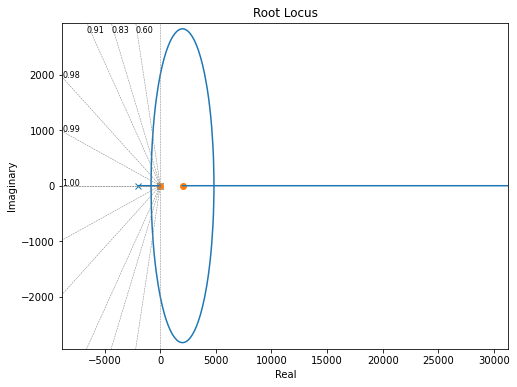

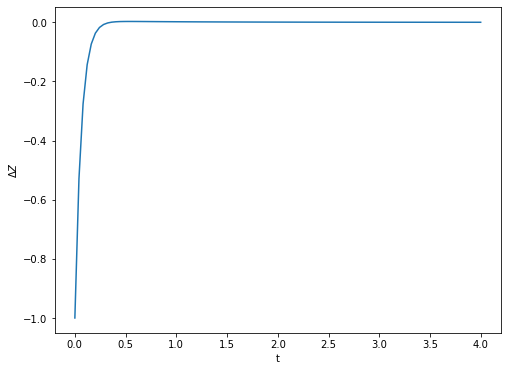

In [96]:
# set parameters
m = 0.03
T = 1e-3

# plot the root locus with a P controller
s = ct.tf('s')
""" sys_P = ct.tf([-T,2],[m*T,2*m,0,0]) """
sys_P=(2-T*s)/(m*s*s*(2+T*s))
print(sys_P)
plt.figure(figsize=(8,6))
ct.root_locus(sys_P)


# plot the root locus with a PD controller
kp = 0.5
kd = 0.5
sys_PD = (2-T*s)/(m*s*s*(2+T*s))*(kp+kd*s)
plt.figure(figsize=(8,6))
ct.root_locus(sys_PD)

# closed-loop response when a PD controller is used
# obtain a minimal realization of the closed-loop transfer function
sys_CL = ct.minreal(sys_PD/(1 + sys_PD))
sys_CL_ss = ct.tf2ss(sys_CL)
print(sys_CL)

# plot the initial condition response
# it will be easier if we deal with a state-space model
# we analyze how to determine the initial condition of the states
# initial condition: \Delta z = -1 and \Delta \dot{z} = 0
# since \Delta z is the output y, we have y = C*x[0] = -1
# moreover, \Delta \dot{z} = \dot{y} = C*\dot{x}[0] = C*A*x[0] = 0
# hence [C; C*A]*x[0] = [-1; 0]
# we can find x[0] accordingly

# initial output
out_init = np.array([[-1],[0]])
coeff_mat = np.vstack((sys_CL_ss.C,np.matmul(sys_CL_ss.C,sys_CL_ss.A)))
# calculate the initial state
x_init = np.matmul(np.linalg.pinv(coeff_mat),out_init)
t=np.linspace(0,4,100)
t_cl, y_cl = ct.initial_response(sys_CL, t, x_init)
plt.figure(figsize=(8,6))
plt.plot(t_cl, y_cl)
plt.xlabel("t")
plt.ylabel("$\Delta Z$")



<br>

<b> Code fragment for time delays </b>

In [97]:
# set parameters
m = 0.03
kz = 4.5e-3

def maximum_delay(gain):
    # pay attention to the units of the returned phase margin
    s = ct.tf('s')
    sys=gain*100/(3*s*(s+0.15))
    _, pm, _, _ =ct.margin(sys)
    omega = np.logspace(-2,2,100)
    mag, _, omega = ct.bode(sys,omega=omega, plot = False)
    index=np.argmin(np.abs(mag-1))
    crossover_f = omega[index]
    max_delay = pm/360*2*np.pi/crossover_f*1000
    return max_delay

for k in [0.5, 2, 4]:
    max_delay = maximum_delay(k)
    print('When the gain k is %.1f, the maximum possible delay is %.4f' % (k, max_delay))

When the gain k is 0.5, the maximum possible delay is 8.6867
When the gain k is 2.0, the maximum possible delay is 2.2648
When the gain k is 4.0, the maximum possible delay is 1.1038


<br>

<b> Code fragment for PID control </b>

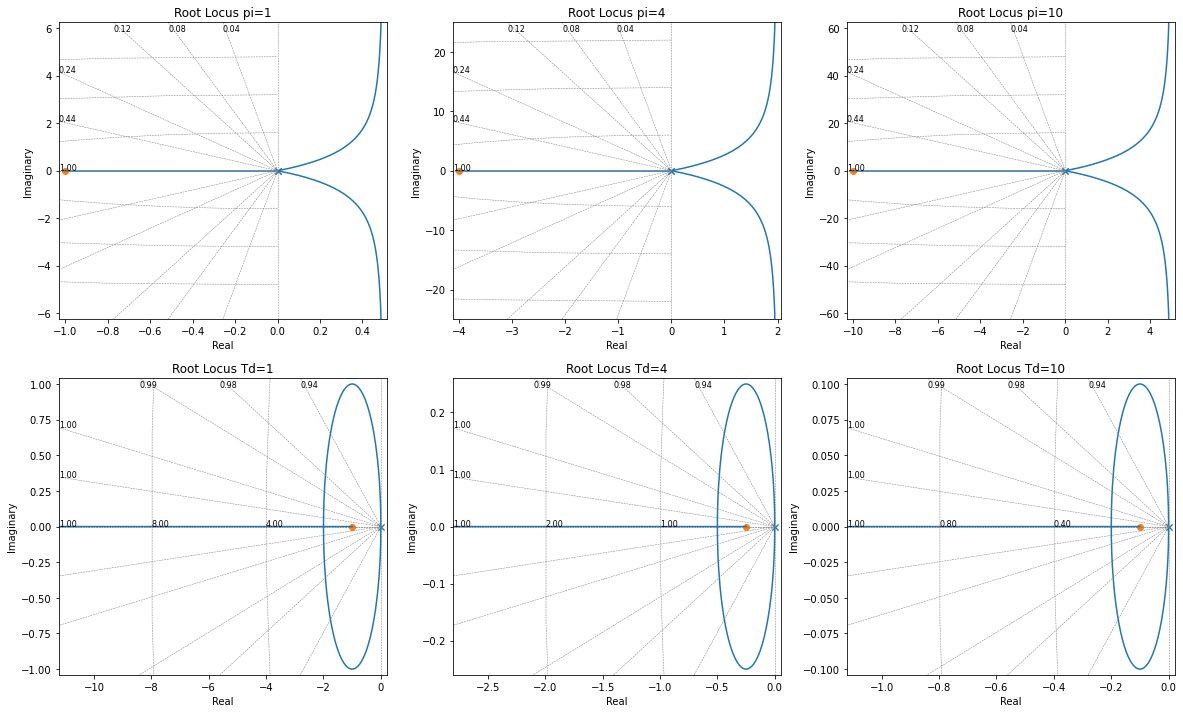

In [98]:
# set parameters
m = 0.03
kp = 1
pi_list = [1,4,10]
Td_list = [1,4,10]

s = ct.tf('s')


plt.figure(figsize=(20,12))
i=1

for pi in pi_list:
  sys_pi = kp*(s+pi)/(m*s*s*s)
  plt.subplot(2,3,i)
  ct.root_locus(sys_pi)
  plt.title(f'Root Locus pi={pi}')
  i+=1

for Td in Td_list:
  sys_pd = kp*(Td*s+1)/(m*s*s)
  plt.subplot(2,3,i)
  ct.root_locus(sys_pd)
  plt.title(f'Root Locus Td={Td}')
  i+=1

<br>

<b> Code fragment for Bode diagrams </b>

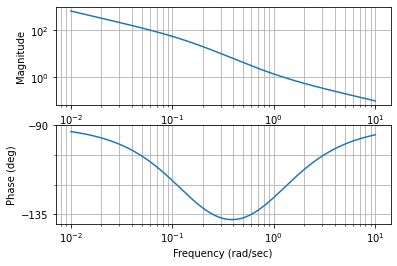

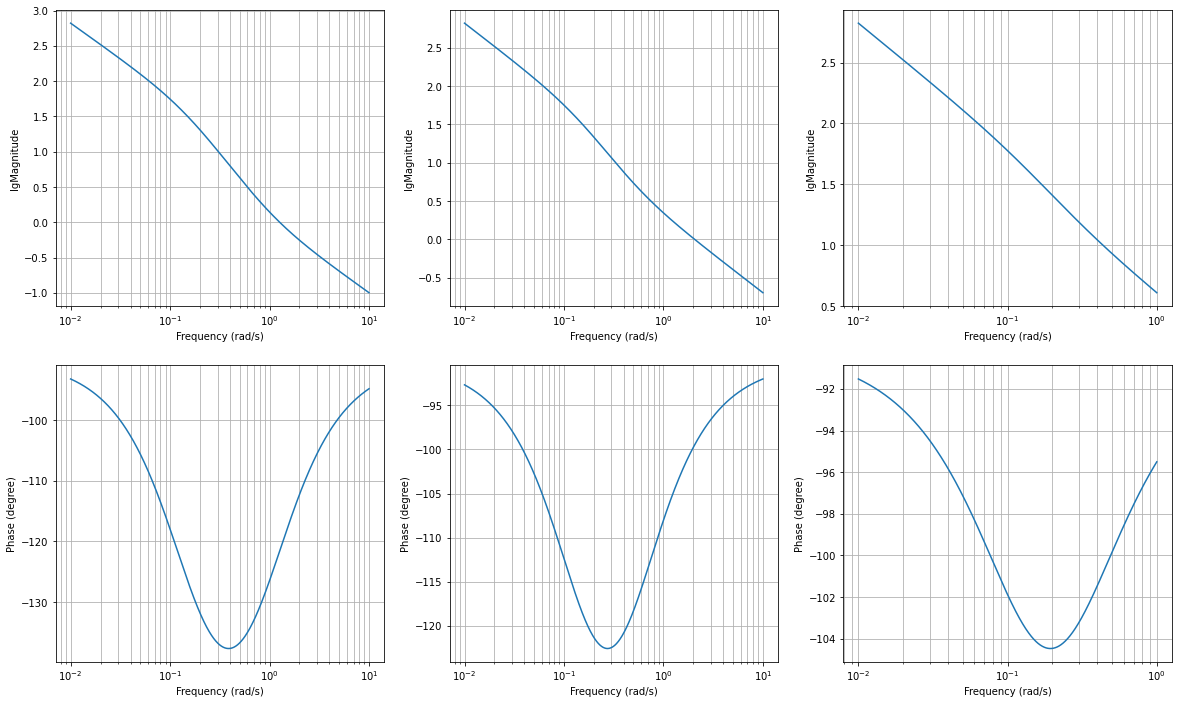

In [99]:
# set parameters
m = 0.03
kz = 4.5e-3

kp = 0.03
Td_list = [1,2,4]
s = ct.tf('s')

sys_pd = kp*(Td_list[0]*s+1)/(m*s*(s+kz/m))
ct.bode(sys_pd)

plt.figure(figsize=(20,12))
i=1

for Td in Td_list:
  sys_pd = kp*(Td*s+1)/(m*s*(s+kz/m))
  plt.subplot(2,3,i)
  mag, phase, omega = ct.bode(sys_pd, plot=False)
  plt.semilogx(omega, np.log10(mag))
  plt.ylabel("lgMagnitude")
  plt.xlabel("Frequency (rad/s)")
  plt.grid(which="both", axis="both")

  plt.subplot(2,3,i+3)
  plt.semilogx(omega, phase/(2*np.pi)*360)
  plt.ylabel("Phase (degree)")
  plt.xlabel("Frequency (rad/s)")
  plt.grid(which="both", axis="both")

  i+=1

<br>

<b> Code fragment for Lead Compensation </b>

In [100]:
# set parameters
m = 0.03
T = 1e-3
kz = 4.5e-3
s = ct.tf('s')

# set the control gain
kp = 0.045

# specify the open-loop transfer function
sys_P = (2-T*s)/(m*s*(s+kz/m)*(2+T*s))
print(sys_P)
# construct the closed-loop transfer function
sys_CL = ct.minreal(sys_P/(1 + sys_P))
print(sys_CL)


         -0.001 s + 2
------------------------------
3e-05 s^3 + 0.06 s^2 + 0.009 s

3 states have been removed from the model

        -33.33 s + 6.667e+04
------------------------------------
s^3 + 2000 s^2 + 266.7 s + 6.667e+04



Text(0.5, 0, 't')

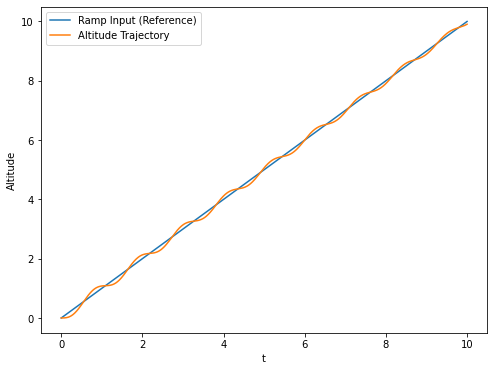

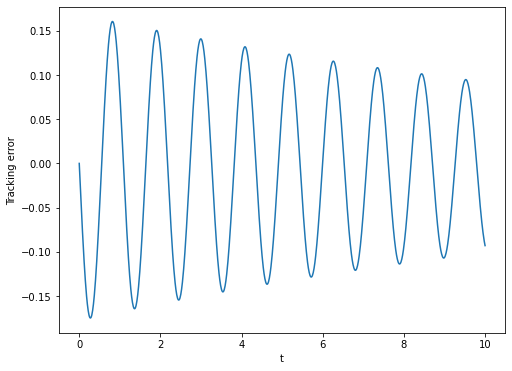

In [101]:
#plot the response with a reference ramp input
tt=np.linspace(0,10,1000)
t, y= ct.forced_response(sys_CL, T=tt, U=1*tt)
plt.figure(figsize=(8,6))
plt.plot(t, t, label="Ramp Input (Reference)")
plt.plot(t, y, label="Altitude Trajectory")
plt.ylabel("Altitude")
plt.xlabel("t")
plt.legend()



# plot the tracking performance of the closed-loop system
plt.figure(figsize=(8,6))
plt.plot(t, y-t)
plt.ylabel("Tracking error")
plt.xlabel("t")


1.1696493275923956
0 states have been removed from the model

          -194.3 s^2 + 3.879e+05 s + 1.314e+06
--------------------------------------------------------
s^4 + 2020 s^3 + 3.969e+04 s^2 + 7.192e+04 s + 1.314e+06

43.290153058005984


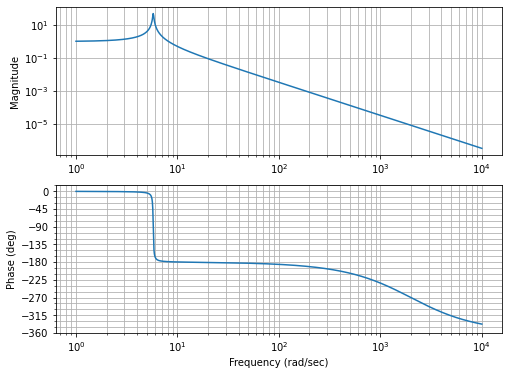

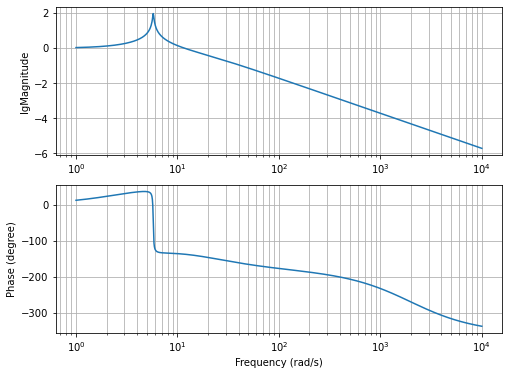

In [102]:
# set the desired phase margin
pm_desired = 40
plt.figure(figsize = (8,6))
mag, phase, omega = ct.bode(sys_CL)
_, pm, _, _ =ct.margin(sys_CL)
print(pm)
""" index = 0
for i in range(len(phase)):
  if phase[i]+180 == pm:
    index=i
crossover_f = omega[i] """
crossover_f = 8.16457

# implement lead compensation

#PM is 1.17,let's suppose it's around 0, we need phase leading of 40
pm_desired+=5 #plus 5 degree as safety factor
alpha = (1-np.sin(pm_desired/360*2*np.pi))/(1+np.sin(pm_desired/360*2*np.pi))
TT = 1/(np.sqrt(alpha)*crossover_f)
sys_phase_lead = ct.minreal(sys_CL*(TT*s+1)/(alpha * TT * s + 1))
print(sys_phase_lead)
plt.figure(figsize = (8,6))
mag, phase, omega = ct.bode(sys_phase_lead, plot = False)
phase = phase+2*np.pi
plt.subplot(2,1,1)
plt.semilogx(omega, np.log10(mag))
plt.ylabel("lgMagnitude")
plt.grid(which="both", axis="both")
plt.subplot(2,1,2)
plt.semilogx(omega, phase/(2*np.pi)*360)
plt.ylabel("Phase (degree)")
plt.xlabel("Frequency (rad/s)")
plt.grid(which="both", axis="both")

_, pm, _, _ =ct.margin(sys_phase_lead)
print(pm)


